In [1]:
import numpy as np
import stat as st
import pandas as pd
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
import scipy.stats as scs
import matplotlib.pyplot as plt
import math
from pandas.tools.plotting import autocorrelation_plot
from pandas import read_csv, DataFrame
from sklearn.metrics import r2_score
import datetime
import copy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Функции

In [6]:
def stat(x):
    _x = x  # Для возможности предобработки данных (например, исключения нечисловых значений) 
    print('счет', len(x))
    print('среднее', (np.mean(_x)))
    print('минимальное', np.min(_x), 'и максимальное', np.max(_x))
    print('стандартное отклонение', pd.core.groupby.GroupBy.std(_x))
    print('дисперсия', np.var(_x))
    print('коэффициент вариации', (np.std(_x)) / (np.mean(_x)))
    print('коэффициент асимметрии', scs.skew(_x))  # асимметрия 
    print('эксцесс', scs.kurtosis(_x)) # эксцесс


def student(data):
    group1 = data[:int((len(data)//2))]
    group2 = data[int(len(data)//2):]
    t_statistic, p_value = scs.ttest_ind(group1, group2)
    print("two-sample t-test:")
    print('p_value =', p_value)
    print('t_statistic =', t_statistic)


def student2(data):
    r = 0
    group1 = data[:int((len(data)//2))]
    group2 = data[int(len(data)//2):]
    if np.var(group1) != np.var(group2):
        t = (abs(np.mean(group1) - np.mean(group2))) / math.sqrt(
            (np.var(group1) / len(group1) + np.var(group2) / len(group2)))
        print('дисперсии не равны')
        print('критерий Стьюдента =', t)
    else:
        t = ((abs(np.mean(group1) - np.mean(group2))) / np.var(group2)) * (math.sqrt(
            (len(group1) * len(group2)) / (len(group1) + len(group2))))
        print('дисперсии равны')
        print('критерий Стьюдента =', t)


def mann2(data):
    group1 = data[:int((len(data)//2))]
    group2 = data[int(len(data)//2):]
    # Если данные не распределены нормально, применяем критерий Манна-Уитни, также известный как 
    # Критерий Уилкоксона для двух выборок
    u, p_value = scs.mannwhitneyu(group1, group2, alternative='two-sided')
    g1 = len(group1)
    g2 = len(group2)
    print('two-sample wilcoxon-test(mann-whitneyu), p_value =', p_value)
    print('U =', u)
    print('M(U) =', g1 * g2 / 2)
    print('D(U) =', g1 * g2 * (g1 + g2 + 1) / 12)
    if (u - (g1 * g2 / 2)) / math.sqrt(g1 * g2 * (g1 + g2 + 1) / 12) > 0:
        z = (u - (g1 * g2 / 2) - 0.5) / math.sqrt(g1 * g2 * (g1 + g2 + 1) / 12)
    else:
        z = (u - (g1 * g2 / 2) + 0.5) / math.sqrt(g1 * g2 * (g1 + g2 + 1) / 12)
    print('Z =', z)



def fisher(data):
    group1 = data[:int((len(data)//2))]
    group2 = data[int(len(data)//2):]
    if np.var(group1) >= np.var(group2):
        f = np.var(group1) / np.var(group2)
    else:
        f = np.var(group2) / np.var(group1)
    print('критерий Фишера =', f)


def acf_and_pacf(data, lags=None):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(data, lags=lags, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(data, lags=lags, ax=ax2)
    plt.show()


def mann(x):
    x = list(x)
    s = [0] * len(x)
    for i in range(len(x)):
        s[i] = i + 1
    k = 1
    t1 = int(len(x) / 2)
    t2 = len(x) - t1
    print('Группа 1 и 2:', t1, 'и', t2)
    for i in range(len(x)):
        if k <= t1:
            x[i] = [x[i], 1]
        else:
            x[i] = [x[i], 2]
        k += 1
    x.sort()
    r1 = 0
    r2 = 0
    for i in range(len(x)):
        if x[i][1] == 1:
            r1 += s[i]
        else:
            r2 += s[i]
    print('сумма рангов r1 =', r1)
    print('сумма рангов r2 =', r2)
    u1 = r1 - (t1 * (t1 + 1)) / 2
    u2 = t1 * t2 - (t2 * ( t2 + 1)) / 2 - r2
    mu = (t1 * t2) / 2
    du = (t1 * t2 * (t1 + t2 + 1)) / 12
    z = (u1 - (t1 * t2) / 2) / (sqrt(du))
    if z > 0:
        z = (u1 - (t1 * t2) / 2 - 1 / 2) / (sqrt(du))
    else:
        z = (u1 - (t1 * t2) / 2 + 1 / 2) / (sqrt(du))
    print('U =', u1)
    print('M(U) =', mu)
    print('D(U) =', du)
    print('Z =', z)
    if -1.96 <= z <= 1.96:
        print('гипотеза о постоянстве постоянстве мат. ожидания принимается')
    else:
        print('гипотеза о постоянстве постоянстве мат. ожидания не принимается')


def sijel(x):
    x = list(x)
    sr = np.mean(x)
    s = [0] * len(x)
    for i in range(int(len(x) / 2)):
        s[i] = 2 * i + 1
        s[-i - 1] = 2 * i + 2
    if s[int(len(x) / 2)] == 0:
        s[int(len(x) / 2)] = 2 * (int(len(x) / 2) + 1)
    k = 1
    t1 = int(len(x) / 2)
    t2 = len(x) - t1
    print('Группа 1 и 2:', t1, 'и', t2)
    for i in range(len(x)):
        x[i] = x[i] - sr
    for i in range(len(x)):
        if k <= t1:
            x[i] = [x[i], 1]
        else:
            x[i] = [x[i], 2]
        k += 1
    x.sort()
    r1 = 0
    r2 = 0
    for i in range(len(x)):
        if x[i][1] == 1:
            r1 += s[i]
        else:
            r2 += s[i]
    print('сумма рангов r1 =', r1)
    print('сумма рангов r2 =', r2)
    mw = r1 - t1* (t1 + t2 + 1) / 2
    dw = (t1 * t2 * (t1 + t2 + 1)) / 12
    z = (r1 - (t1 * ( t1 + t2 + 1)) / 2) / (sqrt(dw))
    if z > 0:
        z = (r1 - (t1 * ( t1 + t2 + 1)) / 2 - 1 / 2) / (sqrt(dw))
    else:
        z = (r1 - (t1 * ( t1 + t2 + 1)) / 2 + 1 / 2) / (sqrt(dw))
    print('M(U) =', mw)
    print('D(U) =', dw)
    print('Z =', z)
    if -1.96 <= z <= 1.96:
        print('гипотеза о постоянстве постоянстве дисперсии принимается')
    else:
        print('гипотеза о постоянстве постоянстве дисперсии не принимается')

In [7]:
df = pd.read_csv('2_goda_dasha.csv', sep=';', keep_default_na=False)
data = df.cost

In [8]:
time = list()
for i in range(df.shape[0]):
    s = df['data'][i]
    time.append(datetime.datetime.fromtimestamp(df['data'][i]).strftime('%d-%m-%Y'))
df['data'] = time

# Решение

In [10]:
stat(data)

счет 732
среднее 1.12866113388
минимальное 1.03851 и максимальное 1.25123
стандартное отклонение 0.0507470035931
дисперсия 0.00257174026115
коэффициент вариации 0.044931403209
коэффициент асимметрии 0.33725965647477224
эксцесс -0.6701990847765913


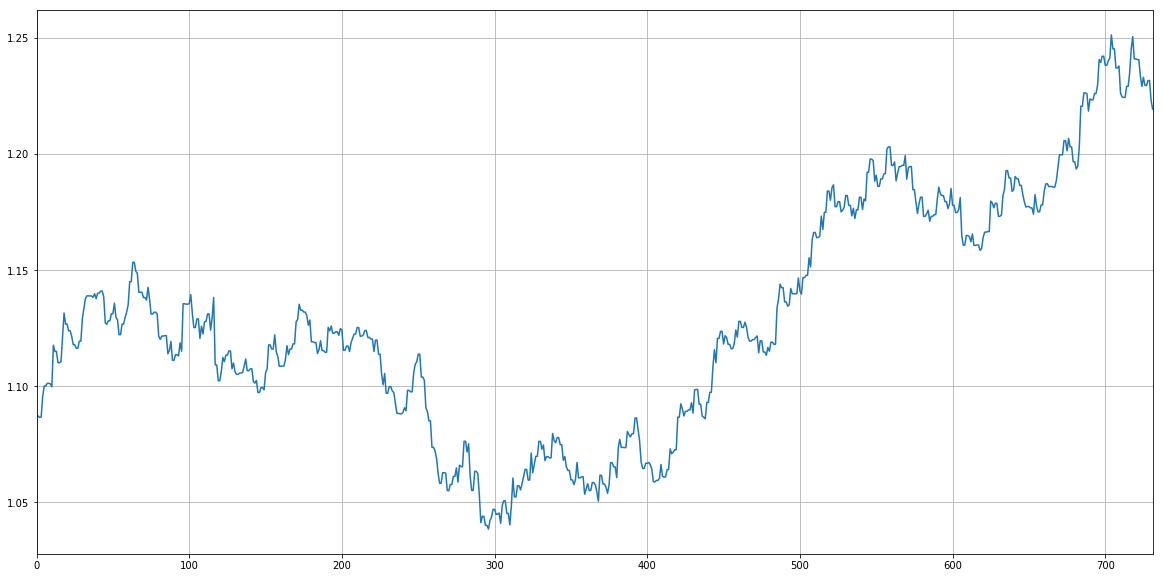

In [11]:
data.plot(figsize=(20, 10), grid=True)
plt.show()

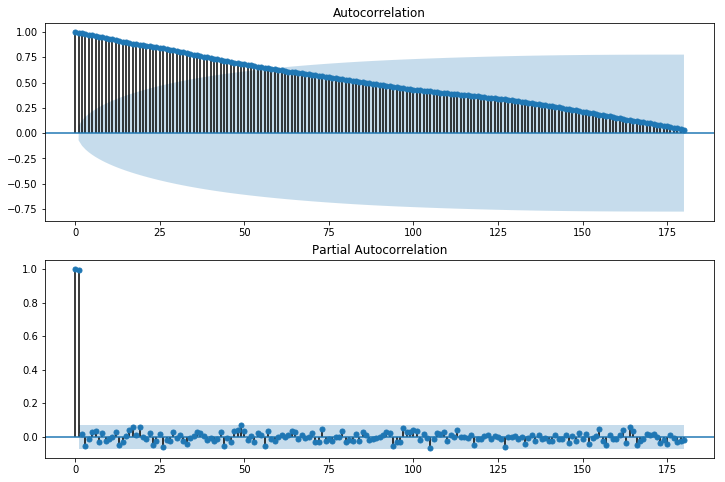

In [12]:
acf_and_pacf(data, lags=180)

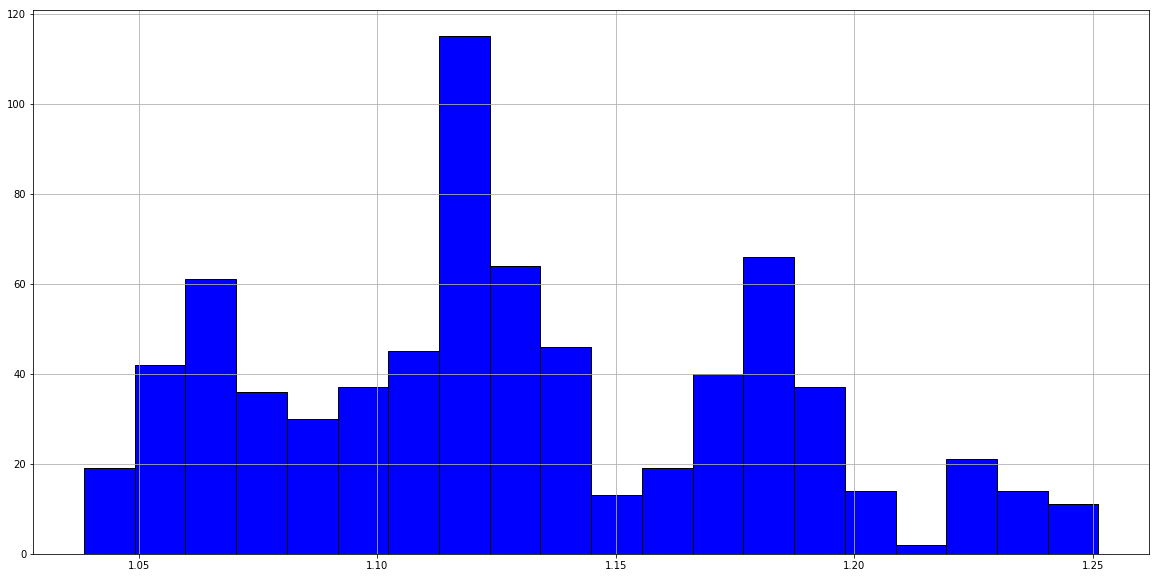

In [13]:
data.hist(figsize=(20, 10), bins=20, color="blue", edgecolor='black')
plt.show()

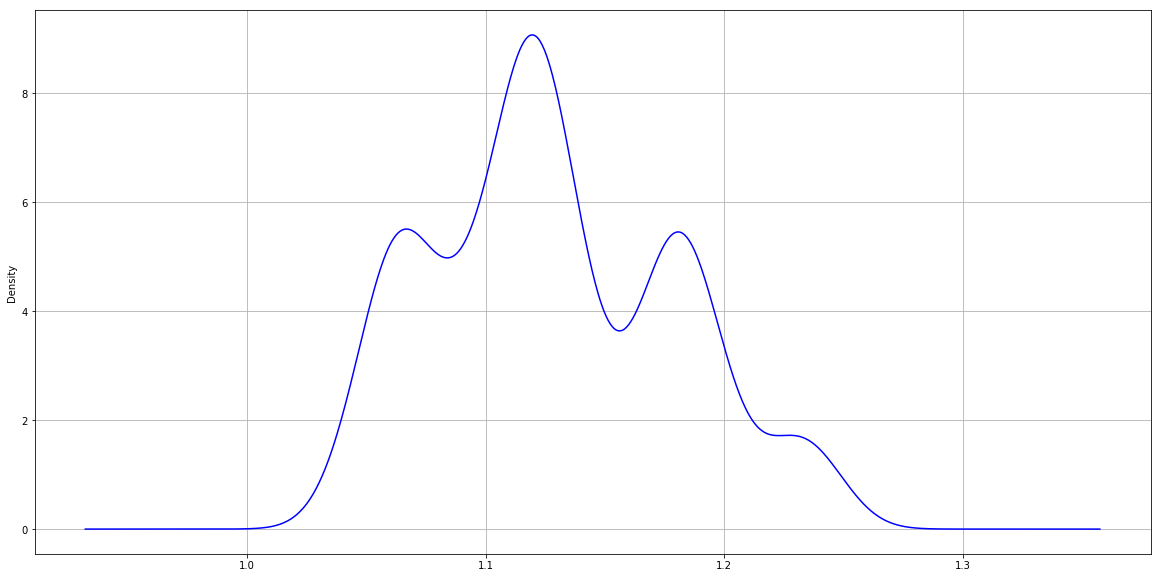

In [14]:
data.plot(figsize=(20, 10), color="blue", kind="kde")
plt.grid()
plt.show()

In [15]:
mann(data)

Группа 1 и 2: 366 и 366
сумма рангов r1 = 94138
сумма рангов r2 = 174140
U = 26977.0
M(U) = 66978.0
D(U) = 8182479.0
Z = -13.9837280789
гипотеза о постоянстве постоянстве мат. ожидания не принимается


In [16]:
sijel(data)

Группа 1 и 2: 366 и 366
сумма рангов r1 = 159726
сумма рангов r2 = 108552
M(U) = 25587.0
D(U) = 8182479.0
Z = 8.94475465285
гипотеза о постоянстве постоянстве дисперсии не принимается


# Первые разности

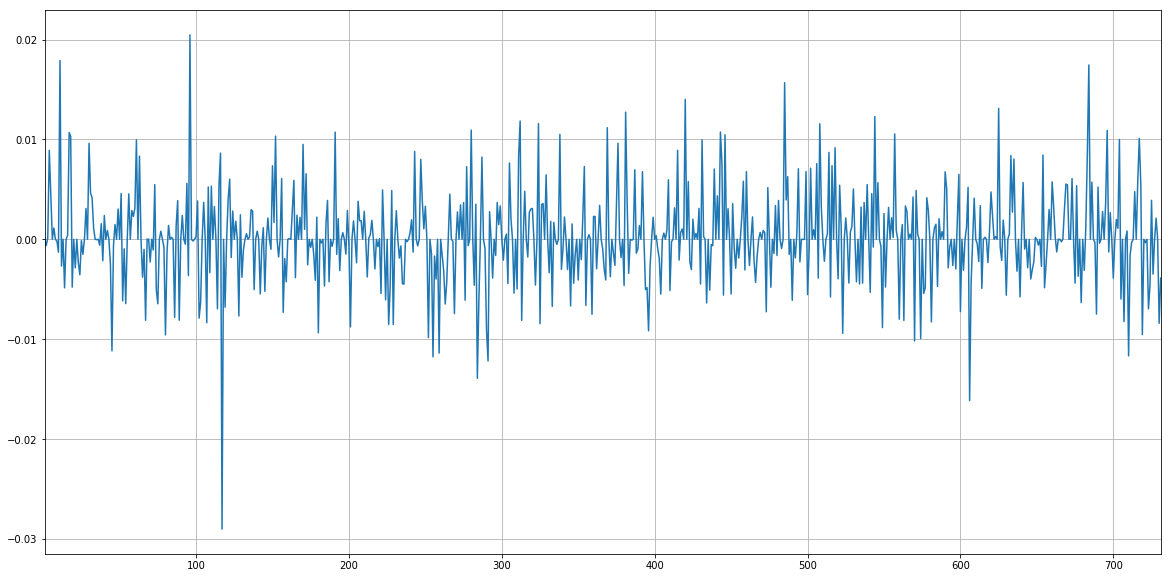

In [17]:
dataR1 = data - data.shift(1)
dataR1[1:].plot(figsize=(20, 10), grid=True)
plt.show()

In [18]:
stat(dataR1[1:])

счет 731
среднее 0.000180711354309
минимальное -0.02901 и максимальное 0.02046
стандартное отклонение 0.00456567017543
дисперсия 2.08168279481e-05
коэффициент вариации 25.247700847
коэффициент асимметрии 0.019552318804865708
эксцесс 3.6856955607507826


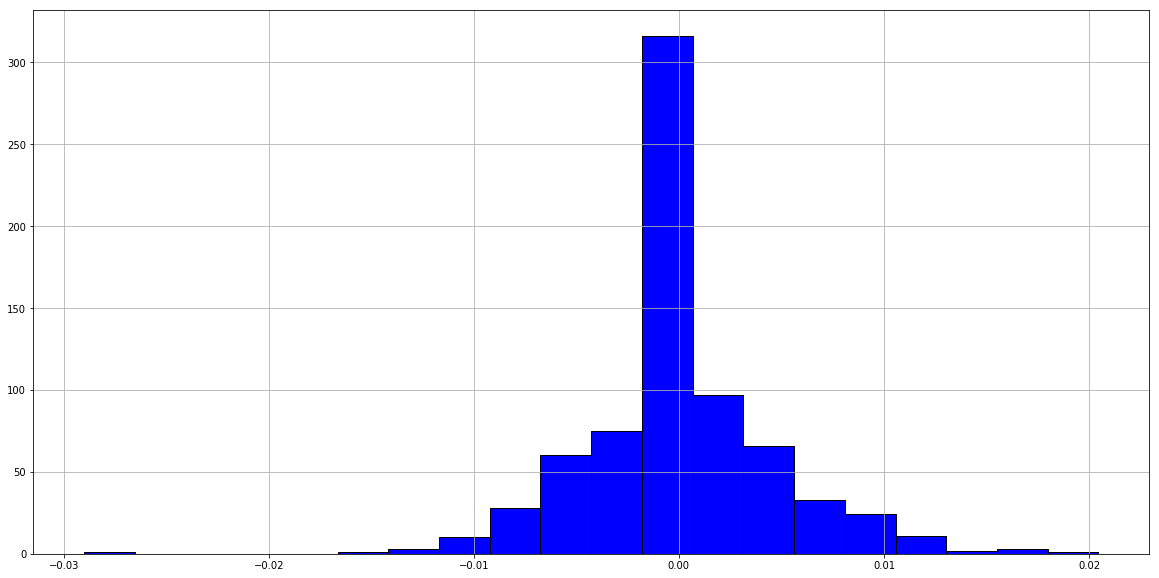

In [19]:
dataR1[1:].hist(figsize=(20,10), bins=20, color="blue", edgecolor='black')
plt.show()

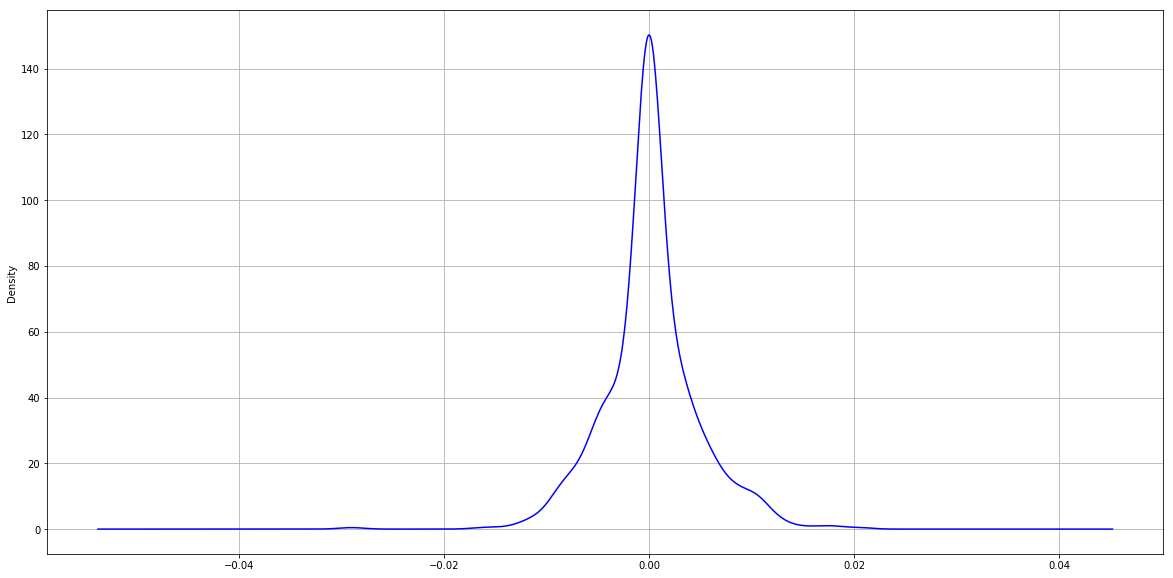

In [20]:
dataR1[1:].plot(figsize=(20, 10), color="blue", kind="kde")
plt.grid()
plt.show()

In [22]:
student2(dataR1[1:])
print('критическое Стьюдент = 1.96')
fisher(dataR1[1:])
print('критическое Фишер = 1.1632')

дисперсии не равны
критерий Стьюдента = 1.53662370494
критическое Стьюдент = 1.96
критерий Фишера = 1.08593146737
критическое Фишер = 1.1632


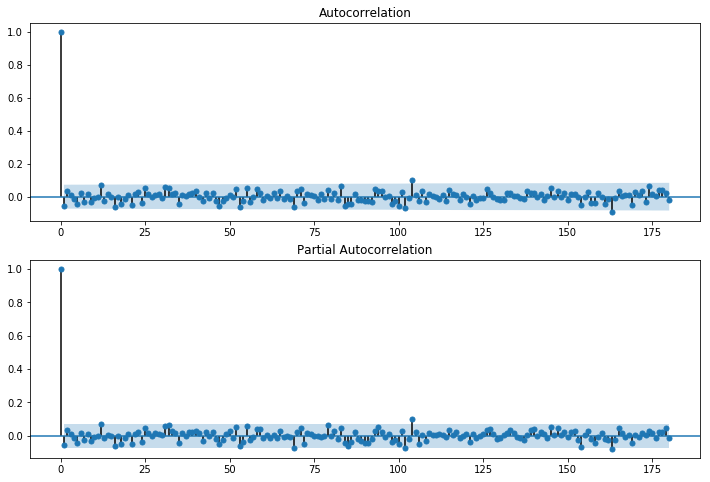

In [23]:
acf_and_pacf(dataR1[1:], lags=180)

# Вторые разности

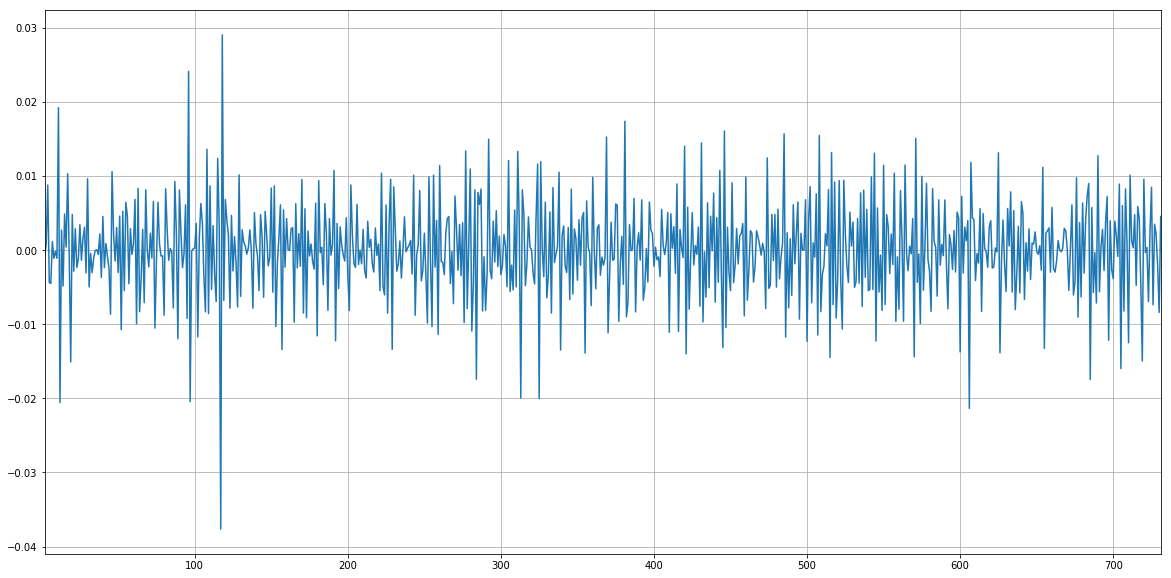

In [24]:
dataR2 = dataR1 - dataR1.shift(1)
dataR2[2:].plot(figsize=(20, 10), grid=True)
plt.show()

In [25]:
stat(dataR2[2:])

счет 730
среднее -5.32876712329e-06
минимальное -0.03764 и максимальное 0.02901
стандартное отклонение 0.00663452268957
дисперсия 4.3956594207e-05
коэффициент вариации -1244.18590365
коэффициент асимметрии -0.23655678565936866
эксцесс 1.9687500542306289


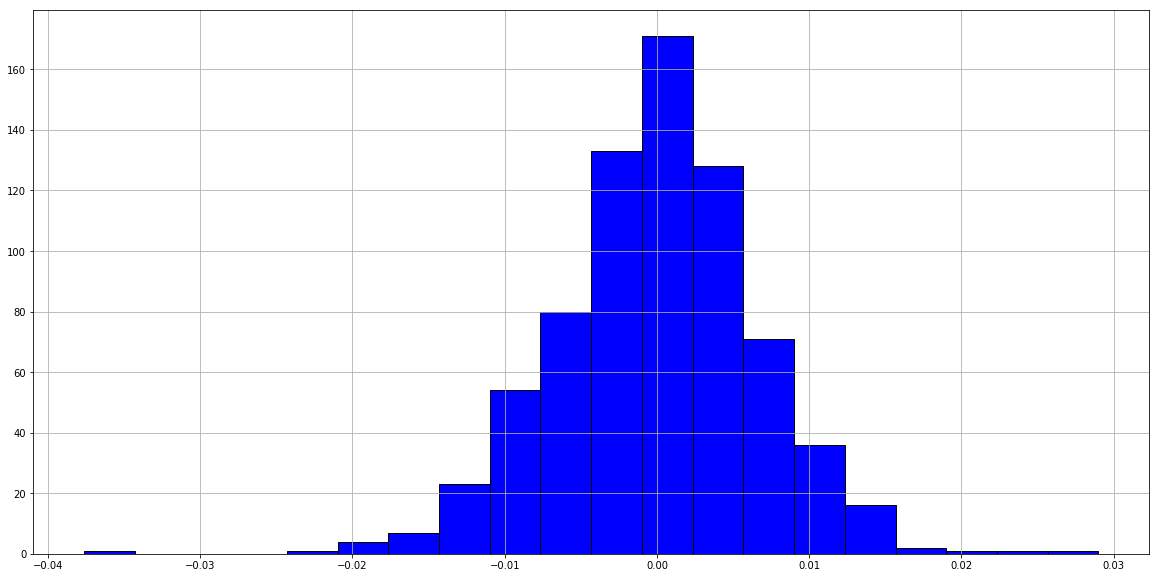

In [26]:
dataR2.hist(figsize=(20,10), bins=20, color="blue", edgecolor='black')
plt.show()

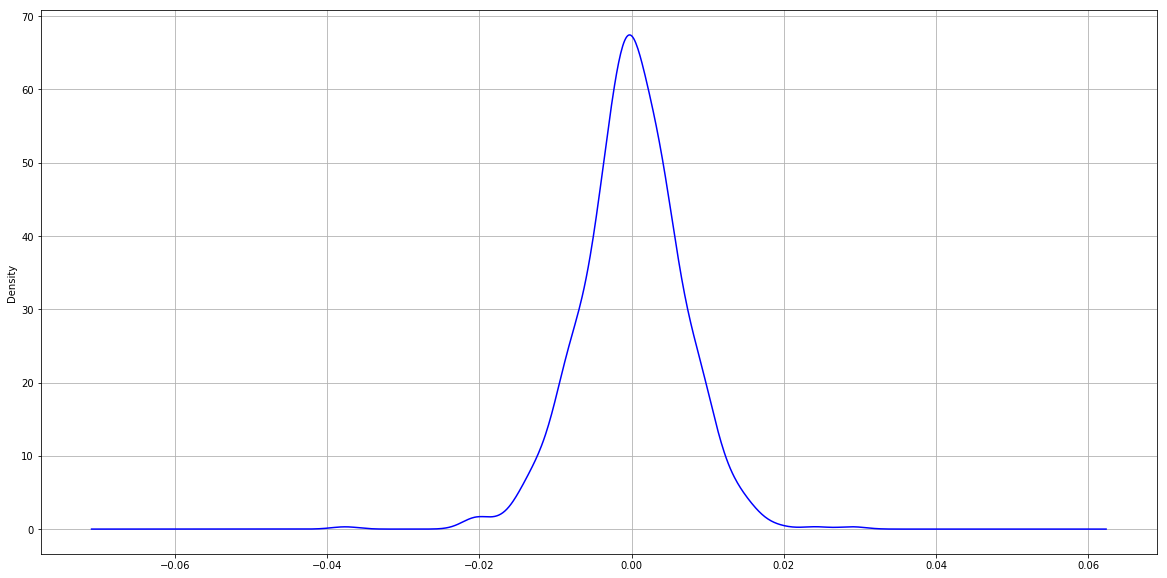

In [27]:
dataR2[2:].plot(figsize=(20, 10), color="blue", kind="kde")
plt.grid()
plt.show()

In [28]:
student2(dataR1[1:])
print('критическое Стьюдент = 1.96')
fisher(dataR1[1:])
print('критическое Фишер = 1.1632')

дисперсии не равны
критерий Стьюдента = 1.53662370494
критическое Стьюдент = 1.96
критерий Фишера = 1.08593146737
критическое Фишер = 1.1632


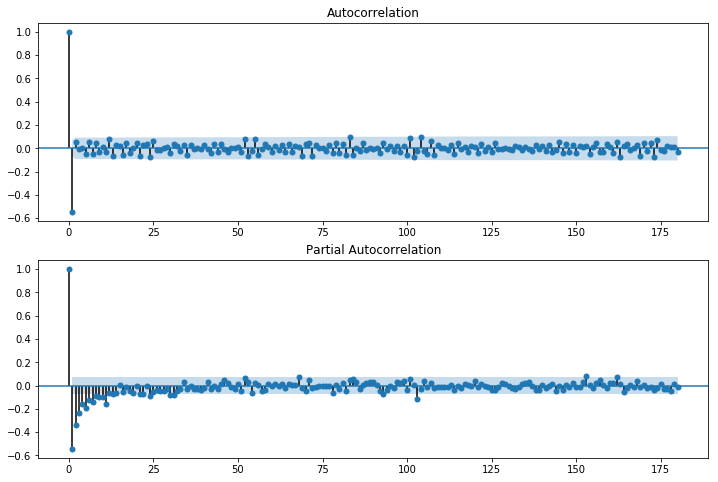

In [29]:
acf_and_pacf(dataR2[2:], lags=180)

# AR(1)

In [30]:
src_data_model = np.array(dataR2[2:])
model = sm.tsa.ARIMA(src_data_model, order=(1,0,0), freq='W').fit(disp=0)
print(model.summary(0.1))

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  730
Model:                     ARMA(1, 0)   Log Likelihood                2753.771
Method:                       css-mle   S.D. of innovations              0.006
Date:                Wed, 27 Jun 2018   AIC                          -5501.543
Time:                        00:34:28   BIC                          -5487.764
Sample:                             0   HQIC                         -5496.227
                                                                              
                 coef    std err          z      P>|z|       [0.05       0.95]
------------------------------------------------------------------------------
const      -7.211e-06      0.000     -0.054      0.957      -0.000       0.000
ar.L1.y       -0.5433      0.031    -17.507      0.000      -0.594      -0.492
                                    Roots           

In [31]:
ar1 = -0.0000007211 + (2 - 0.5433) * data.shift(1) - (1 - 2 * 0.5433) * data.shift(2) - 0.5433 * data.shift(3)
ost_ar1 = data - ar1

In [32]:
stat(ost_ar1[3:])

счет 729
среднее -1.00047614542e-05
минимальное -0.0358789869 и максимальное 0.0190806291
стандартное отклонение 0.00557143741698
дисперсия 3.09983347611e-05
коэффициент вариации -556.496508529
коэффициент асимметрии -0.37923776126095826
эксцесс 2.528396230935064


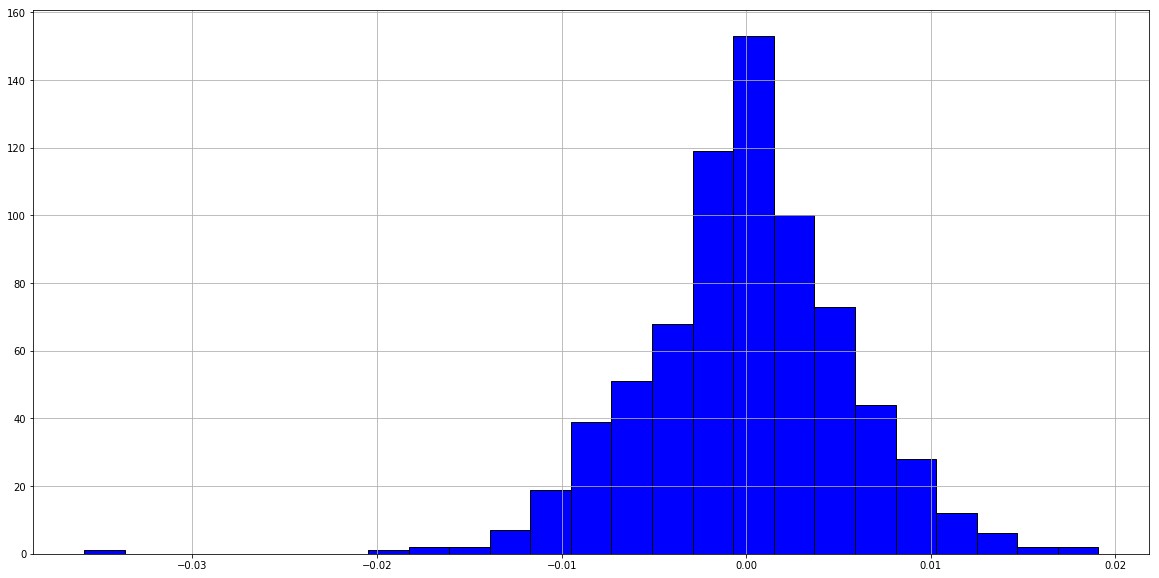

In [33]:
ost_ar1[3:].hist(figsize=(20,10), bins=25, color="blue", edgecolor='black')
plt.show()

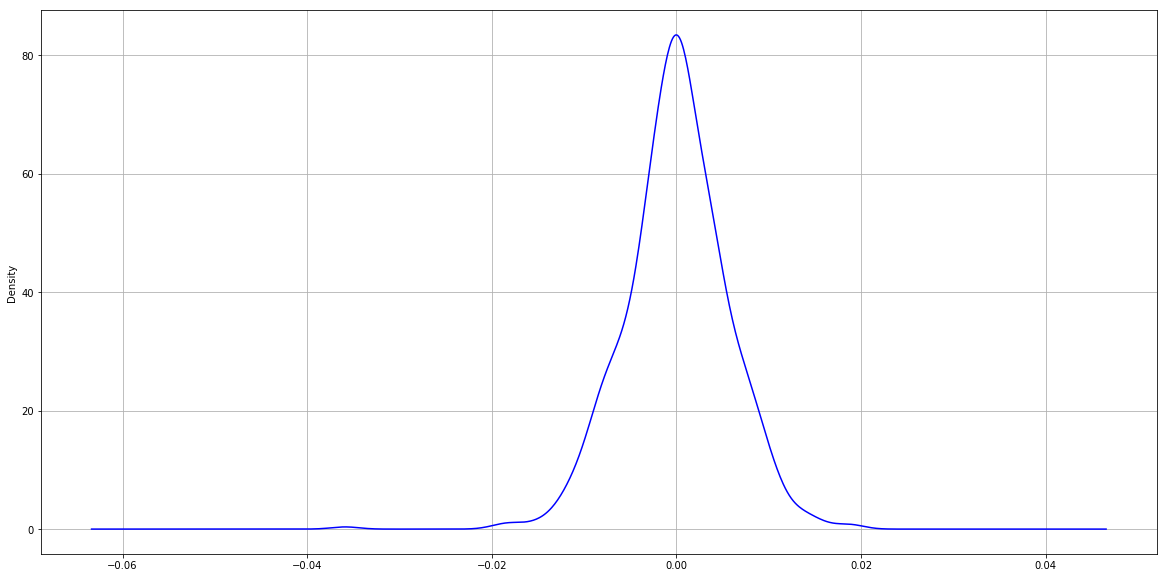

In [34]:
ost_ar1[3:].plot(figsize=(20, 10), color="blue", kind="kde")
plt.grid()
plt.show()

In [35]:
fisher(ost_ar1[3:])

критерий Фишера = 1.12831082062


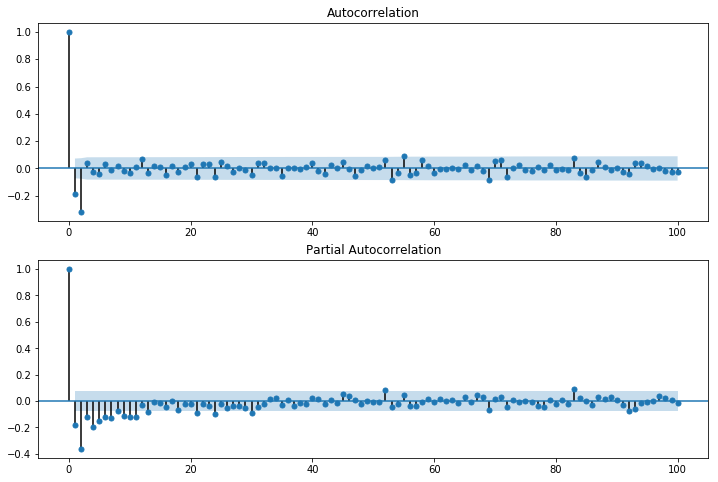

In [36]:
acf_and_pacf(ost_ar1[3:], lags=100)

In [37]:
q_test = sm.tsa.stattools.acf(ost_ar1[3:], qstat=True)
q2 = q_test[0] ** 2
print('Бокс-Пирс', sum(q2[1:]) * 729)
k = 0
j = 1
for i in q2[1:]:
    k = k + i / (729 - j)
    j += 1
print('Льюнг-Бокс', k * 729 * 731)

Бокс-Пирс 128.147563183
Льюнг-Бокс 129.619312797


In [38]:
src_data_model = np.array(dataR2[2:])
model = sm.tsa.ARIMA(src_data_model, order=(1,2,0), freq='W').fit(disp=0)
print(model.summary(0.1))

                             ARIMA Model Results                              
Dep. Variable:                   D2.y   No. Observations:                  728
Model:                 ARIMA(1, 2, 0)   Log Likelihood                2087.505
Method:                       css-mle   S.D. of innovations              0.014
Date:                Wed, 27 Jun 2018   AIC                          -4169.010
Time:                        00:34:59   BIC                          -4155.239
Sample:                             2   HQIC                         -4163.696
                                                                              
                 coef    std err          z      P>|z|       [0.05       0.95]
------------------------------------------------------------------------------
const       4.341e-07      0.000      0.002      0.999      -0.000       0.000
ar.L1.D2.y    -0.7674      0.024    -32.399      0.000      -0.806      -0.728
                                    Roots           

In [39]:
arima = 0.00000004341 + (2 - 0.7674) * data.shift(1) - (1 - 2 * 0.7674) * data.shift(2) - 0.7674 * data.shift(3)
ost_arima = data - arima

In [40]:
stat(ost_arima[3:])

счет 729
среднее -1.33545677505e-05
минимальное -0.03515366741 и максимальное 0.01833814259
стандартное отклонение 0.00576534576772
дисперсия 3.31936161947e-05
коэффициент вариации -431.417192571
коэффициент асимметрии -0.311453014297324
эксцесс 2.0300340432405735


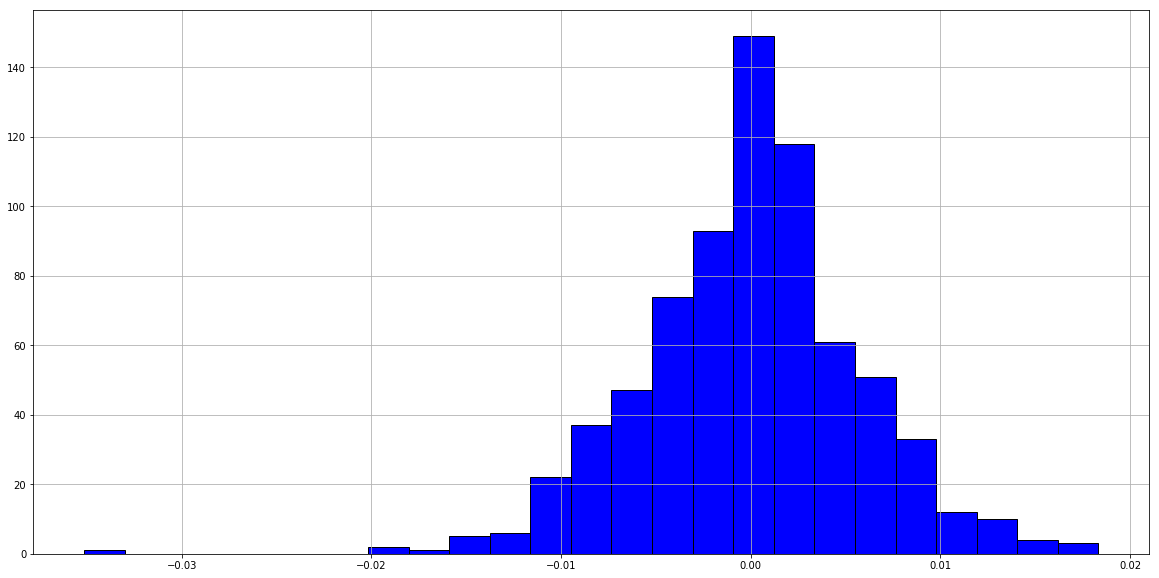

In [41]:
ost_arima[3:].hist(figsize=(20,10), bins=25, color="blue", edgecolor='black')
plt.show()

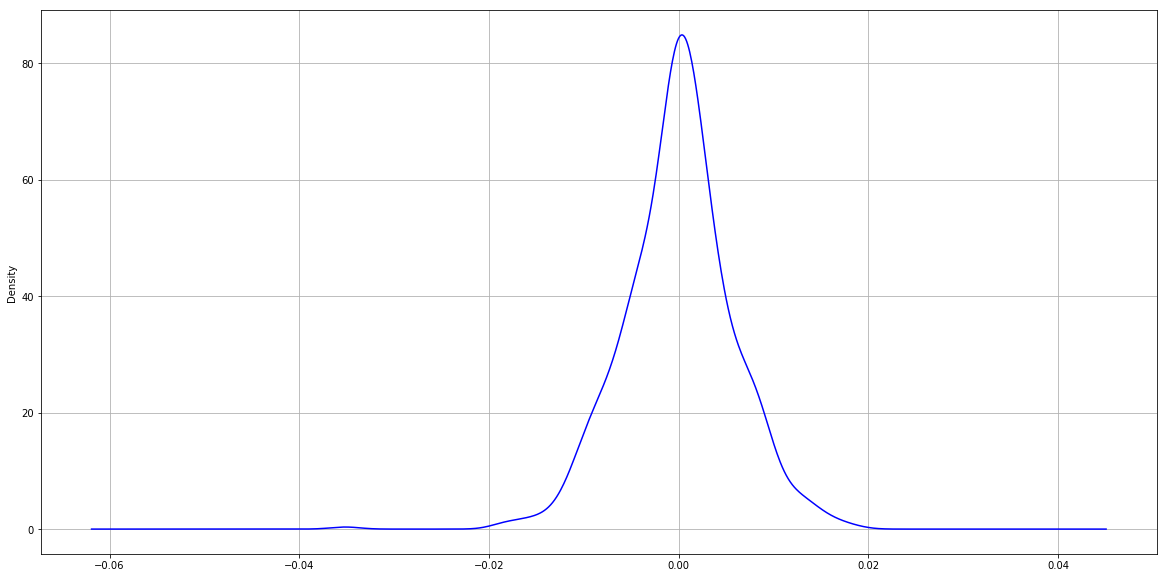

In [42]:
ost_arima[3:].plot(figsize=(20, 10), color="blue", kind="kde")
plt.grid()
plt.show()

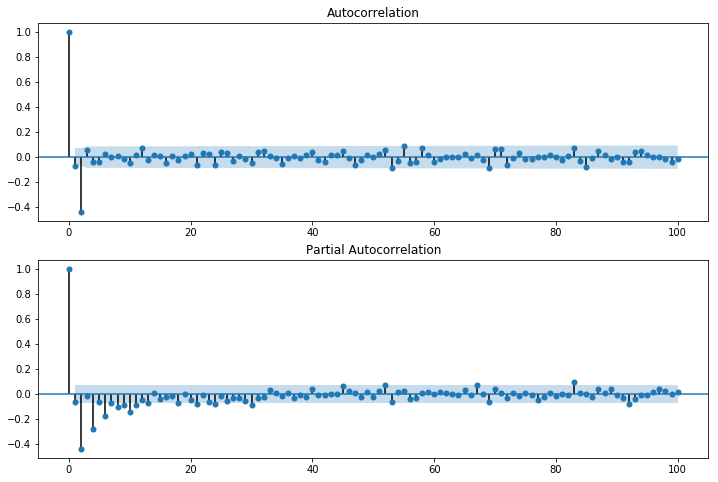

In [43]:
acf_and_pacf(ost_arima[3:], lags=100)

In [44]:
fisher(ost_arima)

критерий Фишера = 1.14235402526


In [45]:
q_test = sm.tsa.stattools.acf(ost_arima[3:], qstat=True)
q2 = q_test[0] ** 2
print('Бокс-Пирс', sum(q2[1:]) * 729)
k = 0
j = 1
for i in q2[1:]:
    k = k + i / (729 - j)
    j += 1
print('Льюнг-Бокс', k * 729 * 731)

Бокс-Пирс 173.677839711
Льюнг-Бокс 175.47414715
